# Персонализация предложения постоянным клиентам комапании «В один клик».

**Задачи проекта:**

Определить покупателей с высоким риском снижения покупательской активности и сформировать предложение заказчику о том, как можно улучшить ситуацию.


**План проекта:**
- Изучение данных;
- Предобработка данных;
- Исследовательский анализ;
- Объединение данных;
- Корреляционный анализ;
- Применение пайплайнов;
- Анализ важности признаков;
- Сегментация покупателя.

**Описание данных:**
1. Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Описание данных:

    - `id` — номер покупателя в корпоративной базе данных.
    - `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    - `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
    - `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    - `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    - `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
    - `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    - `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    - `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
    - `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    - `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
    - `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
    - `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


2. Файл `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Описание данных:
    - `id` — номер покупателя в корпоративной базе данных.
    - `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    - `Выручка` — сумма выручки за период.
    
    
3. Файл `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода. Описание данных:
    - `id` — номер покупателя в корпоративной базе данных.
    - `Период` — название периода, во время которого зафиксировано общее время.
    - `минут` — значение времени, проведённого на сайте, в минутах.


4. Файл `money.csv` содержит данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Описание данных:
    - `id` — номер покупателя в корпоративной базе данных.
    - `Прибыль` — значение прибыли.

In [1]:
!pip install phik -q
!pip install optuna -q
!pip install optuna.integration -q
!pip install shap -q

In [2]:
%pip install -q missingno phik matplotlib==3.9.4 shap==0.47.2 scikit-learn==1.6.1 seaborn==0.13.2

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import phik
import optuna
import shap

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   PolynomialFeatures,
                                   RobustScaler)

from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            precision_score,
                            recall_score,
                            roc_auc_score,
                            f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

In [4]:
def box_hist_plot(data, feature, title, bins):
    """
    Строит распределение и диаграмму размаха для количественных признаков
    """
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    # Строим боксплот вверху
    sns.boxplot(x=data[feature], ax=ax_box)
    # Строим гистограмму внизу
    ax_hist.hist(data[feature], bins=bins)
    plt.xlabel(title)
    plt.ylabel('Количество')
    # Убираем подпись оси X для боксплота
    ax_box.set(xlabel='')
    plt.tight_layout()
    plt.grid()
    plt.show()

In [5]:
def box_count_plot(data, feature, title, xlabel):
    """
    Строит диаграмму количества наблюдений
    """
    plt.subplots(figsize = (10,5))
    sns.countplot(x = data[feature], data =  data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.grid()
    plt.show()


In [6]:
def pie_plotter(data, feature, title):
    """
    Строит круговую диаграмму распределения для категориальных данных
    """
    fig = plt.figure(figsize=(6, 4))
    values = data[feature].value_counts()
    plt.pie(
    values,
    labels = values.index,
    autopct='%1.1f%%',
    )
    plt.title(title)
    
    plt.show()

## Изучение данных

In [7]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

### Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [8]:
# Выводим первые пять строк
market_file.head() 

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
#выведем информацию о датасете
market_file.info()
#посмотрим пропуски в данных
market_file.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

### Данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [10]:
#выводим первые пять строк
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [11]:
#выведем информацию о датасете
market_money.info()
#посмотрим пропуски в данных
market_money.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id         0
Период     0
Выручка    0
dtype: int64

### Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [12]:
#выводим первые пять строк
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [13]:
#выведем информацию о датасете
market_time.info()
#посмотрим пропуски в данных
market_time.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id        0
Период    0
минут     0
dtype: int64

### Данные о среднемесячной прибыли продавца за последние 3 месяца.

In [14]:
#выводим первые пять строк
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [15]:
#выведем информацию о датасете
money.info()
#посмотрим пропуски в данных
money.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id         0
Прибыль    0
dtype: int64

Вывод: 

- Датасет `market_file`: в данных имеется 1300 записей, пропуски отсутствуют, явные дубликаты отсутствуют, названия столбцов имеют разный тип;
- Датасет `market_money`: в данных имеется 3900 записей, пропуски отсутствуют, явные дубликаты отсутствуют;
- Датасет `market_time`: в данных имеется 2600 записей, пропуски отсутствуют, явные дубликаты отсутствуют;
- Датасет `money`: в данных имеется 1300 записей, пропуски отсутствуют, явные дубликаты отсутствуют.

Все типы данных в датасетах верные, изменят не нужно.

## Предобработка данных

### Переименование столбцов

In [16]:
#создадим фунцию, которая заменяет '_' на пробел и приводит текст к нижнему регистру
def normalize_col_names(col_names):
    return [col.lower().replace('_', ' ') for col in col_names]

In [17]:
market_file.columns = normalize_col_names(market_file.columns)
market_file.columns

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет актив 6 мес', 'маркет актив тек мес', 'длительность',
       'акционные покупки', 'популярная категория',
       'средний просмотр категорий за визит',
       'неоплаченные продукты штук квартал', 'ошибка сервиса',
       'страниц за визит'],
      dtype='object')

In [18]:
market_money.columns = normalize_col_names(market_money.columns)
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [19]:
market_time.columns = normalize_col_names(market_time.columns)
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [20]:
money.columns = normalize_col_names(money.columns)
money.columns

Index(['id', 'прибыль'], dtype='object')

### Обработка неявных дубликатов

#### market_file

In [21]:
#посмотрим униклаьные значения покупательской активности
market_file['покупательская активность'] = market_file['покупательская активность'].str.lower()
market_file['покупательская активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [22]:
#посмотрим униклаьные значения типа сервиса
market_file['тип сервиса'] = market_file['тип сервиса'].str.lower()
market_file['тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [23]:
#заменим неявный дубликат
market_file['тип сервиса'] = market_file['тип сервиса'].replace('стандартт', 'стандарт')
market_file['тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [24]:
#посмотрим униклаьные значения столбца разрешить сообщать
market_file['разрешить сообщать'] = market_file['разрешить сообщать'].str.lower()
market_file['разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [25]:
#посмотрим униклаьные значения популярной категории
market_file['популярная категория'] = market_file['популярная категория'].str.lower()
market_file['популярная категория'].unique()

array(['товары для детей', 'домашний текстиль', 'косметика и аксесуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

In [26]:
#заменим опечатку
market_file['популярная категория'] = market_file['популярная категория'].apply(lambda x : x.replace('аксесуары', 'аксессуары'))
market_file['популярная категория'].unique()

array(['товары для детей', 'домашний текстиль', 'косметика и аксессуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

#### market_money

In [27]:
#посмотрим униклаьные значения столбца период
market_money['период'] = market_money['период'].str.lower()
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [28]:
#заменим '_' на пробел
market_money['период'] = market_money['период'].apply(lambda x : x.replace('_', ' '))
market_money['период'].unique()

array(['препредыдущий месяц', 'текущий месяц', 'предыдущий месяц'],
      dtype=object)

#### market_time

In [29]:
market_time['период'] = market_time['период'].str.lower()
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [30]:
#заменим опечатку
market_time['период'] = market_time['период'].apply(lambda x : x.replace('предыдцщий', 'предыдущий'))
#заменим '_' на пробел
market_time['период'] = market_time['период'].apply(lambda x : x.replace('_', ' '))
market_time['период'].unique()

array(['текущий месяц', 'предыдущий месяц'], dtype=object)

### Обработка явных дубликатов

In [31]:
#проверим данные на явные дубликаты
print('Количество явных дубликатов market_file:', market_file.duplicated().sum())
print('Количество явных дубликатов market_money:', market_money.duplicated().sum())
print('Количество явных дубликатов market_time:', market_time.duplicated().sum())
print('Количество явных дубликатов money:', money.duplicated().sum())

Количество явных дубликатов market_file: 0
Количество явных дубликатов market_money: 0
Количество явных дубликатов market_time: 0
Количество явных дубликатов money: 0


Вывод:
- Привели названия столбцов к одному виду;
- Обработали неявные дубликаты, исправили опечатки;
- Явные дубликаты не выявлены.

## Исследовательский анализ

### market_file

In [32]:
market_file.describe()

,id,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


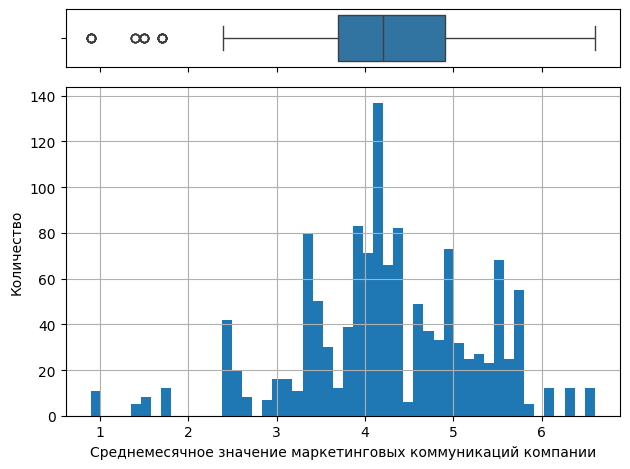

In [33]:
box_hist_plot(market_file, 'маркет актив 6 мес', 'Среднемесячное значение маркетинговых коммуникаций компании', 50)

Вывод: распределние похоже на нормальное, имеются выбросы, оставим признак без изменений.

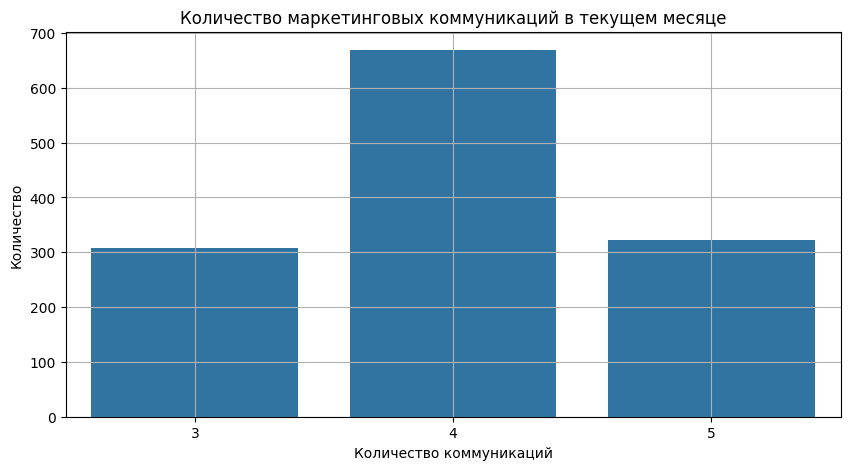

In [34]:
box_count_plot(market_file,
               'маркет актив тек мес',
               'Количество маркетинговых коммуникаций в текущем месяце',
               'Количество коммуникаций')

Вывод: распределние не похоже на нормальное, имеются выбросы, скрее всего из-за спеццифики признака. Оставим признак без изменений.

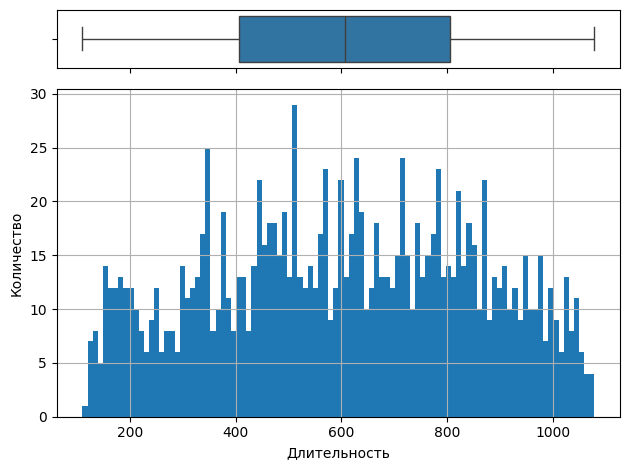

In [35]:
box_hist_plot(market_file, 'длительность', 'Длительность', 100)

Вывод: распределение похоже на нормальное, но имеет асимметрию, выбросы отсутствуют.

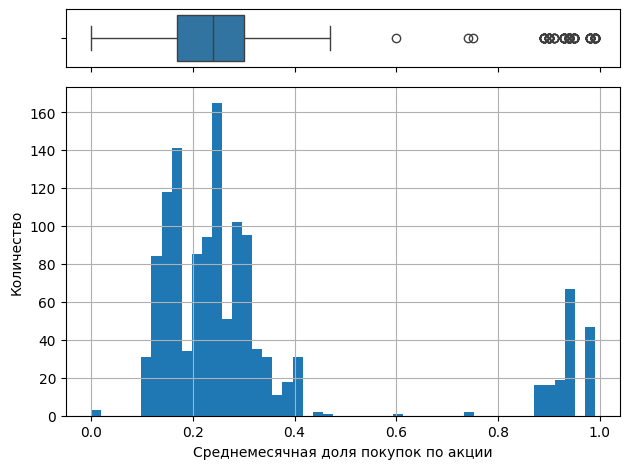

In [36]:
box_hist_plot(market_file, 'акционные покупки', 'Среднемесячная доля покупок по акции', 50)

Вывод: нормальное распределение с асимметрией, имеются выбросы. Выбросы можно объяснить тем, что некоторые покупатели делали большую часть покупок по акции

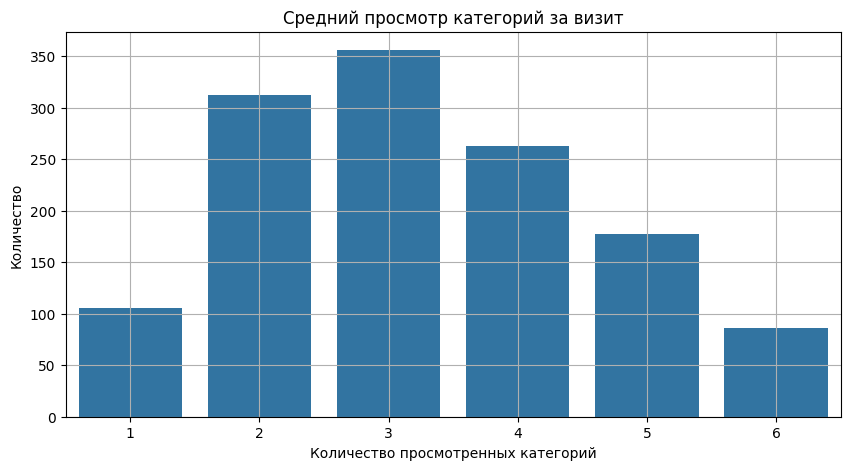

In [37]:
box_count_plot(market_file,
               'средний просмотр категорий за визит',
               'Средний просмотр категорий за визит',
               'Количество просмотренных категорий')

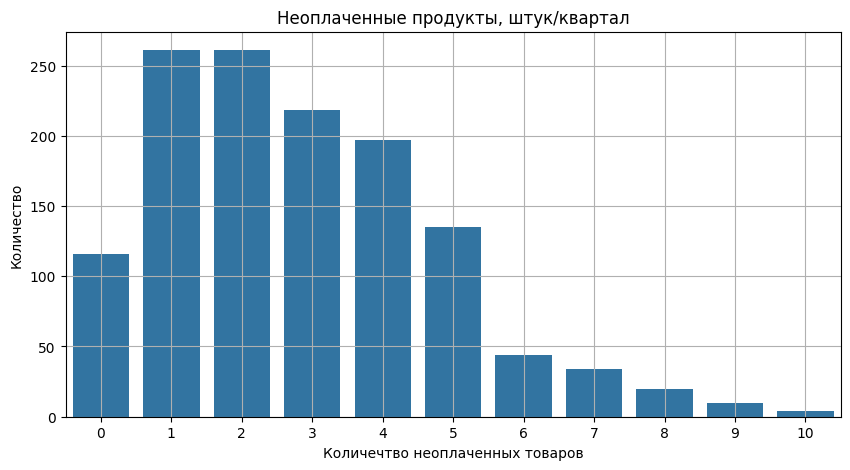

In [38]:
box_count_plot(market_file,
               'неоплаченные продукты штук квартал',
               'Неоплаченные продукты, штук/квартал',
               'Количечтво неоплаченных товаров')

Вывод: нормальное распределение с асимметрией, выбросов нет.

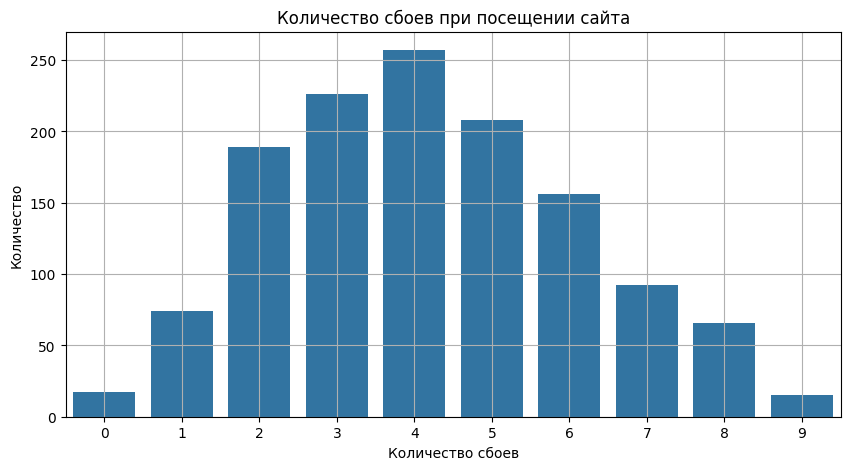

In [39]:
box_count_plot(market_file,
               'ошибка сервиса',
               'Количество сбоев при посещении сайта',
               'Количество сбоев')

Вывод: нормальное распределение с асимметрией, выбросов нет.

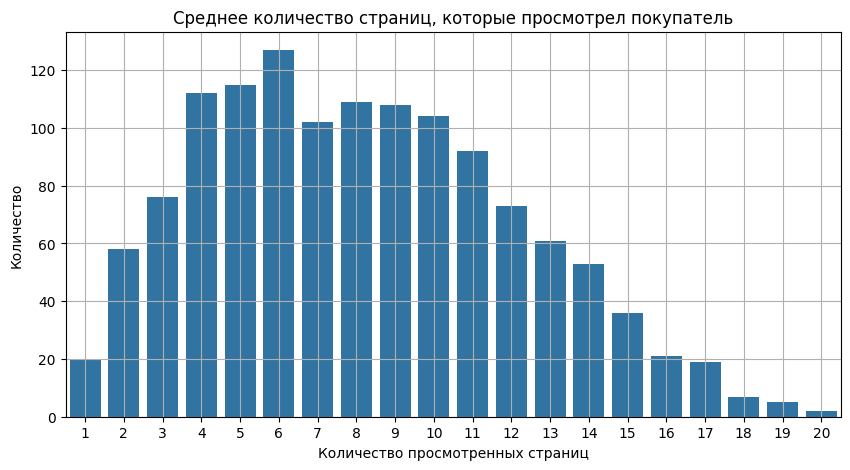

In [40]:
box_count_plot(market_file,
               'страниц за визит',
               'Среднее количество страниц, которые просмотрел покупатель',
               'Количество просмотренных страниц')

Вывод: нормальное распределение с асимметрией, выбросов нет.

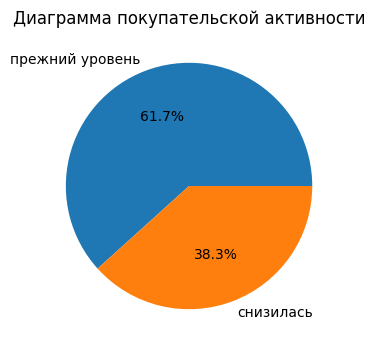

In [41]:
pie_plotter(market_file, 'покупательская активность', 'Диаграмма покупательской активности')

В данных присутствует дисбаланс целевой переменной, это нужно учитывать при выборе метрики для отбора лучшей модели.

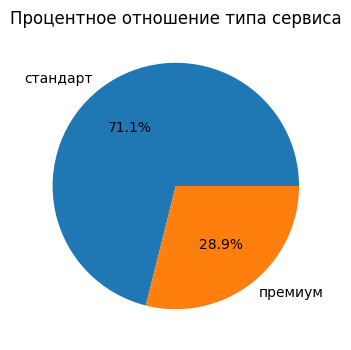

In [42]:
pie_plotter(market_file, 'тип сервиса', 'Процентное отношение типа сервиса')

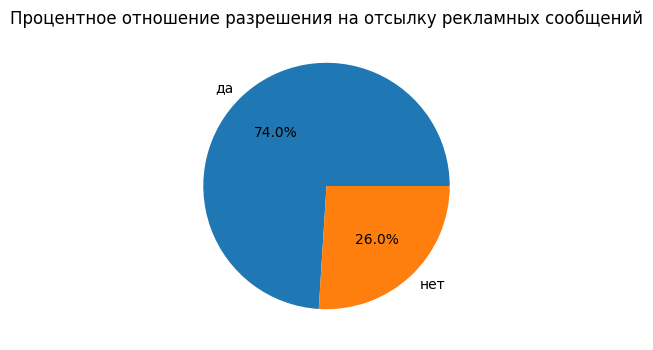

In [43]:
pie_plotter(market_file, 'разрешить сообщать', 'Процентное отношение разрешения на отсылку рекламных сообщений')

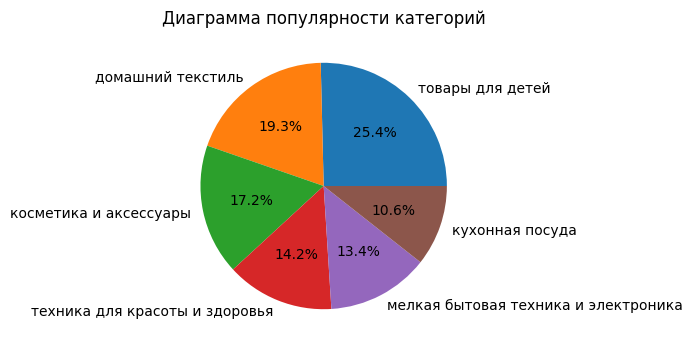

In [44]:
pie_plotter(market_file, 'популярная категория', 'Диаграмма популярности категорий')

### market_money

In [45]:
market_money.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


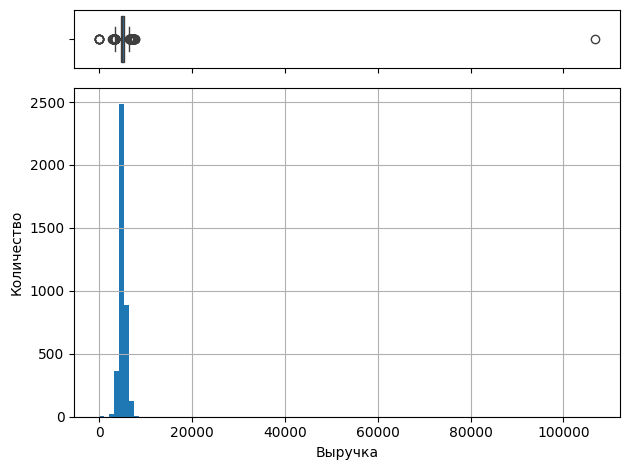

In [46]:
box_hist_plot(market_money, 'выручка', 'Выручка', 100)

Вывод: по графику видно, что значение большее 100 000 является выбросром. Проверим сколько таких значений

In [47]:
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий месяц,106862.2


In [48]:
#удаляем строку с выбросом
market_money = market_money.loc[market_money['выручка'] < 100000]

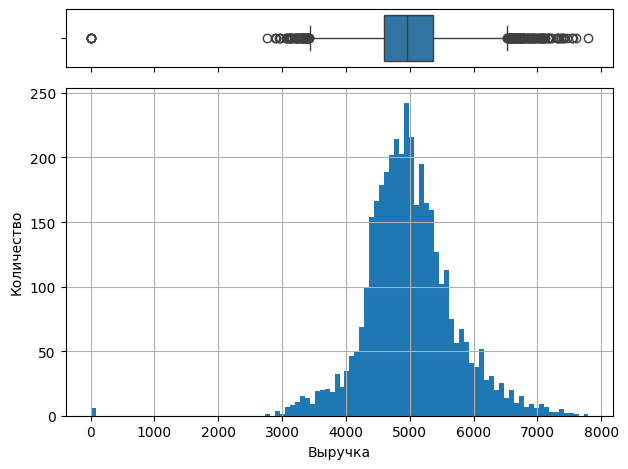

In [49]:
box_hist_plot(market_money, 'выручка', 'Выручка', 100)

In [50]:
current_month = market_money.loc[market_money['период'] == 'текущий месяц']
current_month.head(1)

,id,период,выручка
1,215348,текущий месяц,3293.1


In [51]:
previous_month = market_money.loc[market_money['период'] == 'предыдущий месяц']
previous_month.head(1)

,id,период,выручка
2,215348,предыдущий месяц,0.0


In [52]:
preprevious_month = market_money.loc[market_money['период'] == 'препредыдущий месяц']
preprevious_month.head(1)

,id,период,выручка
0,215348,препредыдущий месяц,0.0


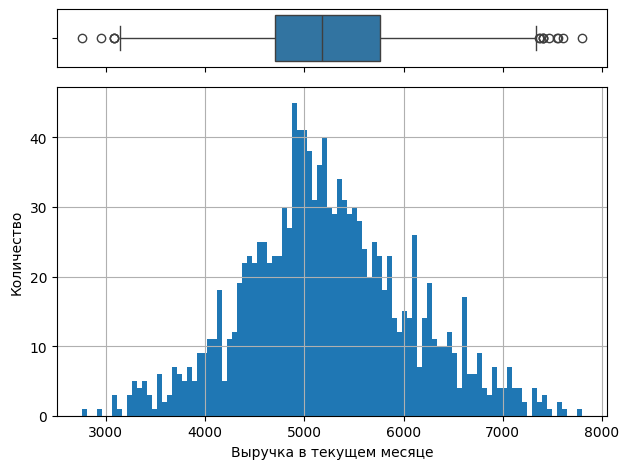

In [53]:
box_hist_plot(current_month, 'выручка', 'Выручка в текущем месяце', 100) 

Вывод: нормальное распределение с асимметрией, имеются выбросы, выбросы не стоит удалять, так как они могут повлиять на качество модели.

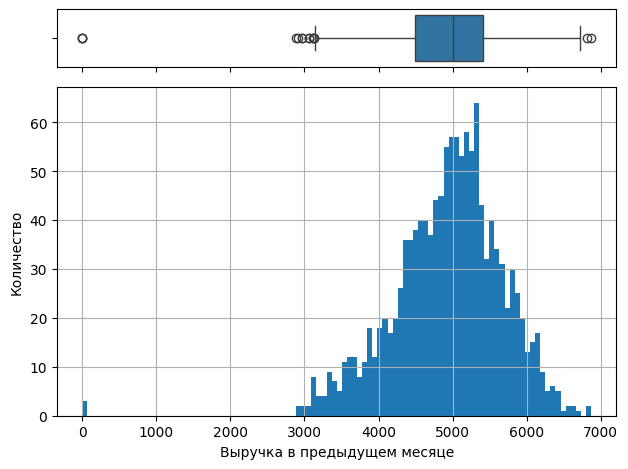

In [54]:
box_hist_plot(previous_month, 'выручка', 'Выручка в предыдущем месяце', 100) 

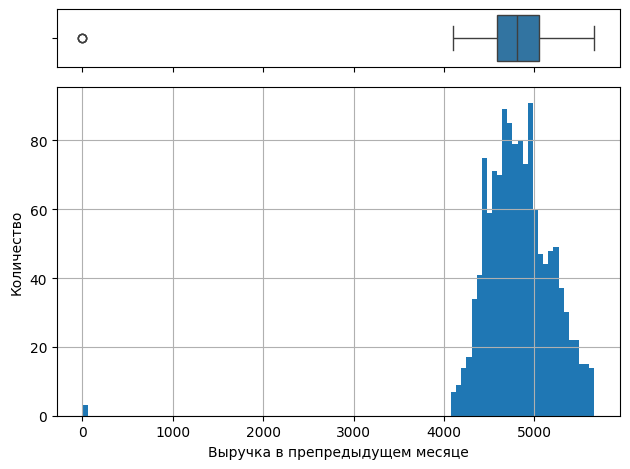

In [55]:
box_hist_plot(preprevious_month, 'выручка', 'Выручка в препредыдущем месяце', 100) 

Вывод: нормальное распределение с асимметрией, имеются выбросы, но они могут быть, потому что некоторые пользователи могли не совершать покупок.

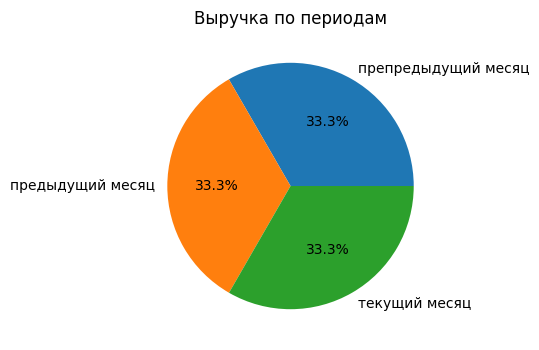

In [56]:
pie_plotter(market_money, 'период', 'Выручка по периодам')

### market_time

In [57]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


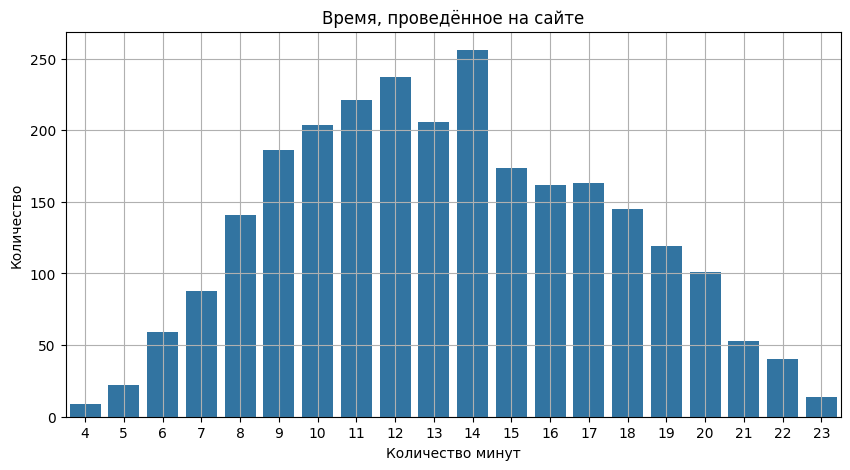

In [58]:
box_count_plot(market_time,
               'минут',
               'Время, проведённое на сайте',
               'Количество минут')

Вывод: нормальное распределение с асимметрией, выбросов нет.

In [59]:
current_month_1 = market_time.loc[market_time['период'] == 'текущий месяц']
current_month_1.head(1)

,id,период,минут
0,215348,текущий месяц,14


In [60]:
previous_month_1 = market_time.loc[market_time['период'] == 'предыдущий месяц']
previous_month_1.head(1)

,id,период,минут
1,215348,предыдущий месяц,13


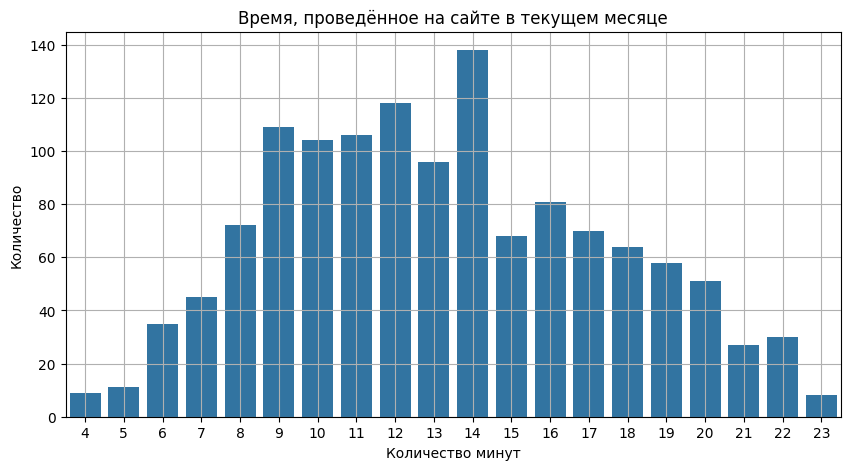

In [61]:
box_count_plot(current_month_1,
               'минут',
               'Время, проведённое на сайте в текущем месяце',
               'Количество минут')

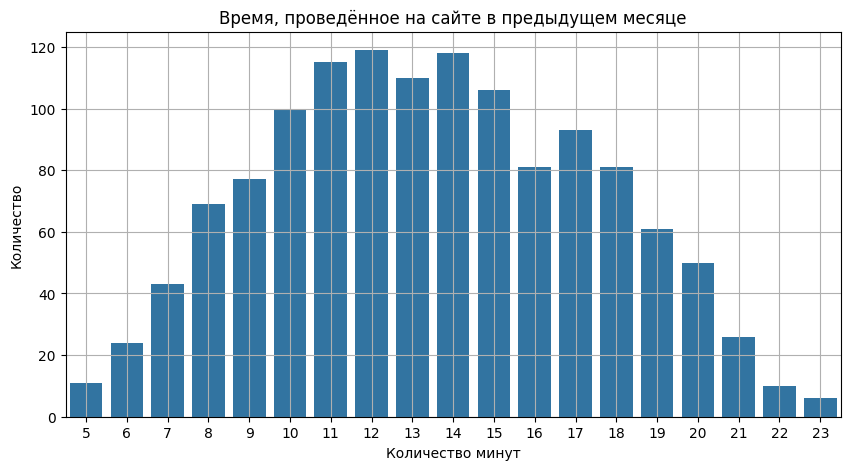

In [62]:
box_count_plot(previous_month_1,
               'минут',
               'Время, проведённое на сайте в предыдущем месяце',
               'Количество минут')

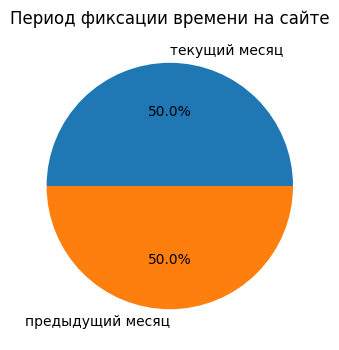

In [63]:
pie_plotter(market_time, 'период', 'Период фиксации времени на сайте')

### money

In [64]:
money.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


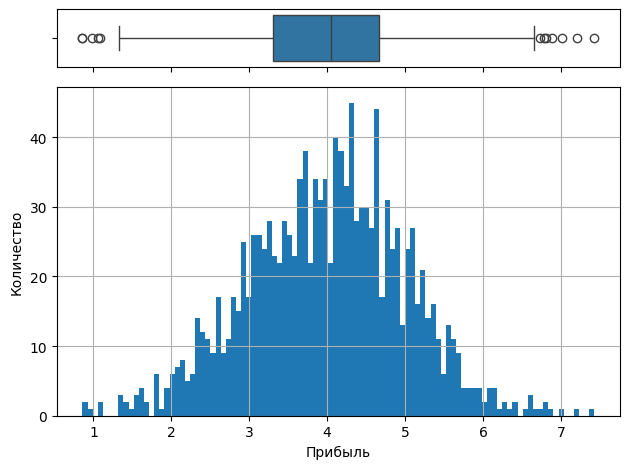

In [65]:
box_hist_plot(money, 'прибыль', 'Прибыль', 100)

Вывод: нормальное распределение с асимметрией, выбросов нет. Значения в пределах нормы, обработка не требуется.

### Отбор клиентов с покупательской активностью не менее трёх месяцев

In [66]:
inactive_users = market_money.groupby('id').prod().query('выручка == 0')
inactive_users

,выручка
id,
215348,0.0
215357,0.0
215359,0.0


In [67]:
market_file = market_file.loc[~market_file['id'].isin([215348, 215357, 215359]), :]
market_file.shape

(1297, 13)

Вывод: обнаружены выбросы в данных. Выбросы могут быть связаны с сезонностью продаж, особенностью активности отдельных покупателей, также не исключены ошибки ввода данных.

Из результатов исследования данных видим, что большая доля покупок состоит из товаров для детей (25,4%), 74% клиентов согласились на рекламную рассылку, немного меншее количество имеют стандартный тип сервиса, и 62% сохранили свою покупательную активность. 

Активные пользователи за последние 3 месяца отобраны, полный перечень находится в таблице market_file (1297 покупателей).

## Объединение данных

In [68]:
market_money_grouped = market_money.set_index(['id', 'период']).выручка.unstack().add_prefix('выручка ')
market_money_grouped.head()

период,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [69]:
market_time_grouped = market_time.set_index(['id', 'период']).минут.unstack().add_prefix('минут ')
market_time_grouped.head()

период,минут предыдущий месяц,минут текущий месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [70]:
data = market_file.merge(market_money_grouped, on='id', how='inner').merge(market_time_grouped, on='id', how='inner')
data.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц,минут предыдущий месяц,минут текущий месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [71]:
#проверим размерности данных
print(market_file.shape)
print(market_money_grouped.shape)
print(market_time_grouped.shape)
print(data.shape)

(1297, 13)
(1300, 3)
(1300, 2)
(1297, 18)


Вывод: объеденили таблицы, количество строк итоговой таблицы соответствует количеству строк исходных таблиц, количество столбцов равно сумме столбцов исходных таблиц.

In [72]:
data.isna().sum()

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет актив 6 мес                     0
маркет актив тек мес                   0
длительность                           0
акционные покупки                      0
популярная категория                   0
средний просмотр категорий за визит    0
неоплаченные продукты штук квартал     0
ошибка сервиса                         0
страниц за визит                       0
выручка предыдущий месяц               0
выручка препредыдущий месяц            0
выручка текущий месяц                  1
минут предыдущий месяц                 0
минут текущий месяц                    0
dtype: int64

Имеется один пропуск в столбце `выручка текущий месяц`, удалим значение, так как вероятнее всего за данный перод не было совершено покупок.

In [73]:
data = data.dropna()
data.isna().sum()

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет актив 6 мес                     0
маркет актив тек мес                   0
длительность                           0
акционные покупки                      0
популярная категория                   0
средний просмотр категорий за визит    0
неоплаченные продукты штук квартал     0
ошибка сервиса                         0
страниц за визит                       0
выручка предыдущий месяц               0
выручка препредыдущий месяц            0
выручка текущий месяц                  0
минут предыдущий месяц                 0
минут текущий месяц                    0
dtype: int64

## Корреляционный анализ

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет актив 6 мес                   1296 non-null   float64
 5   маркет актив тек мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные покупки                    1296 non-null   float64
 8   популярная категория                 1296 non-null   object 
 9   средний просмотр категорий за визит  1296 non-null   int64  
 10  неоплаченные продукты штук квартал   1296 non-null   int64  
 11  ошибка сервиса                

In [75]:
interval_cols=['маркет актив 6 мес',
               'маркет актив тек мес',
               'длительность',
               'акционные покупки',
               'средний просмотр категорий за визит',
               'неоплаченные продукты штук квартал',
               'ошибка сервиса',
               'страниц за визит',
               'выручка предыдущий месяц',
               'выручка препредыдущий месяц',
               'выручка текущий месяц',
               'минут предыдущий месяц',
               'минут текущий месяц']

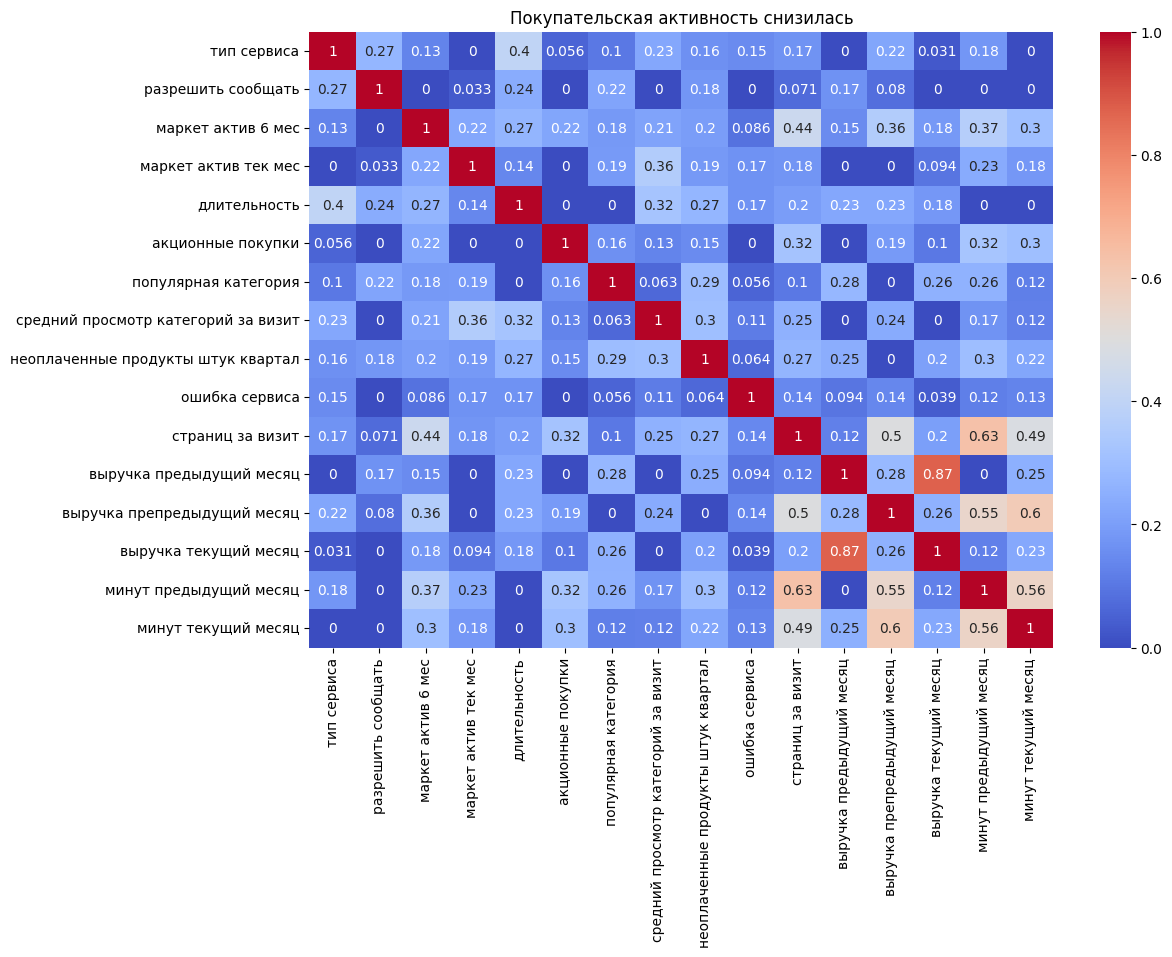

In [76]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[data['покупательская активность'] == 'снизилась']
            .drop(['id', 'покупательская активность'], axis=1)
            .phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Покупательская активность снизилась')
plt.show()

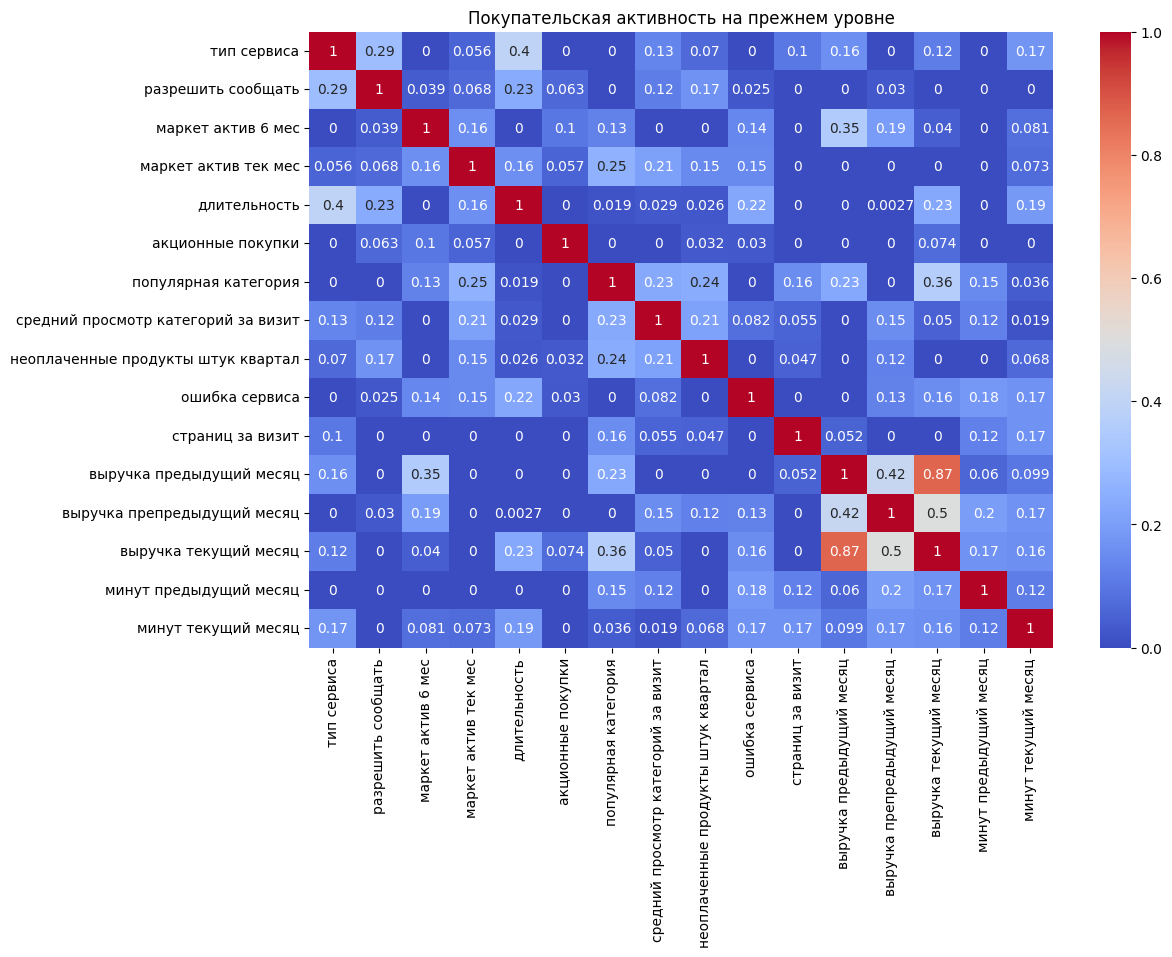

In [77]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[data['покупательская активность'] == 'прежний уровень']
            .drop(['id', 'покупательская активность'], axis=1)
            .phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Покупательская активность на прежнем уровне')
plt.show()

Вывод: при мультиколлинеарности наблюдается сильная зависимость между входными признаками. Примем, что признаки с коэффициентом корреляции выше 0,9 имеют мультиколлинеарность. Мультиколлинеарность отсутствует.

## Применение пайплайнов

Будем использовать метрику ROC-AUC, так как она отображает истинную и постоянную способность модели к прогнозирования. В общем случае метрика ROC-AUC должна стремится к 1. Кривая ROC показывает соотношение между чувствительностью и специфичностью при различных порогах принятия решения. AUC (Area Under Curve) показывает, насколько хорошо модель различает классы.

In [78]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# разделим выборку на тренировочную и тестовую
X = data.drop(['id', 'покупательская активность'], axis=1)
y = data['покупательская активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print('Train:', X_train.shape, y_train.shape )
print('Test:', X_test.shape, y_test.shape)
le = LabelEncoder()
le = LabelEncoder()
le.fit_transform(y_train.unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

Train: (972, 16) (972,)
Test: (324, 16) (324,)
Значениям ['прежний уровень' 'снизилась'] назначено соответственно [0 1]


In [79]:
# разбиваем данные на количественные и категориальные
ohe_columns = ['популярная категория']
ord_columns = ['тип сервиса', 'разрешить сообщать']
num_columns = ['маркет актив 6 мес',
               'маркет актив тек мес',
               'длительность',
               'акционные покупки',
               'средний просмотр категорий за визит',
               'неоплаченные продукты штук квартал',
               'ошибка сервиса',
               'страниц за визит',
               'выручка предыдущий месяц',
               'выручка препредыдущий месяц',
               'выручка текущий месяц',
               'минут предыдущий месяц',
               'минут текущий месяц']

In [80]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns:
# SimpleImputer + Ordinal-кодирование
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
            ['премиум', 'стандарт'],
            ['да', 'нет']
        ],
             handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём пайплайн для подготовки признаков из списка num_columns:
# SimpleImputer + Ordinal-кодирование
num_pipe = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2))
])

In [81]:
# создаем единый пайплайн
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [82]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier())
    ]
)

In [83]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 50),
        'models__max_features': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',penalty='l1')],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

# обучаем модель на тренировочной выборке
randomized_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['популярная '
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='mos...
                                                                       solver='liblinear')],
                                         'models__C': range(1, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 15),
                                         'models__kernel': ['poly', 'rbf',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [84]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                    

In [85]:
print('Площадь ROC-кривой на кросс-валидации:', randomized_search.best_score_)
roc_auc_test = roc_auc_score(y_test, randomized_search.predict_proba(X_test)[:, 1])
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_test)
roc_auc_km = (roc_auc_test - randomized_search.best_score_) / randomized_search.best_score_*100
print(f'Потеря качества на тестовой выборке  = {roc_auc_km:.2f} %')

Площадь ROC-кривой на кросс-валидации: 0.8959925247561611
Площадь ROC-кривой на тестовой выборке: 0.9165554342110586
Потеря качества на тестовой выборке  = 2.29 %


Вывод: лучшей моделью является модель `LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')`
- Площадь ROC-кривой на тренировочной выборке: 0.897
- Площадь ROC-кривой на тестовой выборке: 0.919

## Анализ важности признаков

In [86]:
best_model = randomized_search.best_estimator_.named_steps['models']
best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
feature_names = best_preprocessor.get_feature_names_out()

X_train_trans = pd.DataFrame(best_preprocessor.transform(X_train), columns=feature_names)
X_test_trans = pd.DataFrame(best_preprocessor.transform(X_test), columns=feature_names)

explainer = shap.Explainer(best_model.predict_proba, X_train_trans)
shap_values = explainer(X_test_trans)

PermutationExplainer explainer: 325it [00:10,  2.20it/s]                         


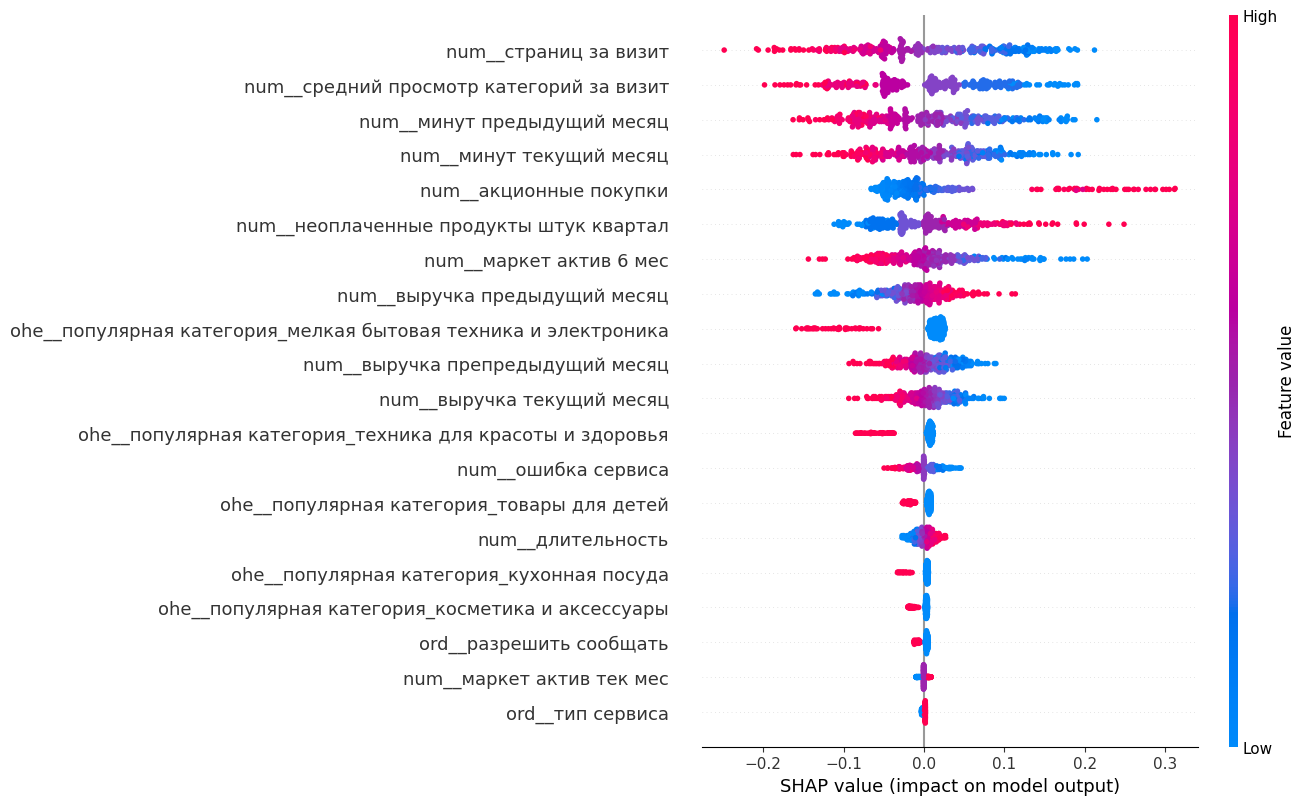

In [87]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=25) 

Вывод: 

- Количество страниц за визит имеет сильную отрицательную зависимость. Это указвает на то, что большее количество страниц, приводит к повышению покупательской активность. То же самое с признаками средний просмотр категорий за визит и временем, проведенном на сайте.


- Положительную зависимость имеют акционные покупки. Это означает, что увеличение акционных покупок, приведет к снижению покупательской активность. То же с неоплаченными товарами.

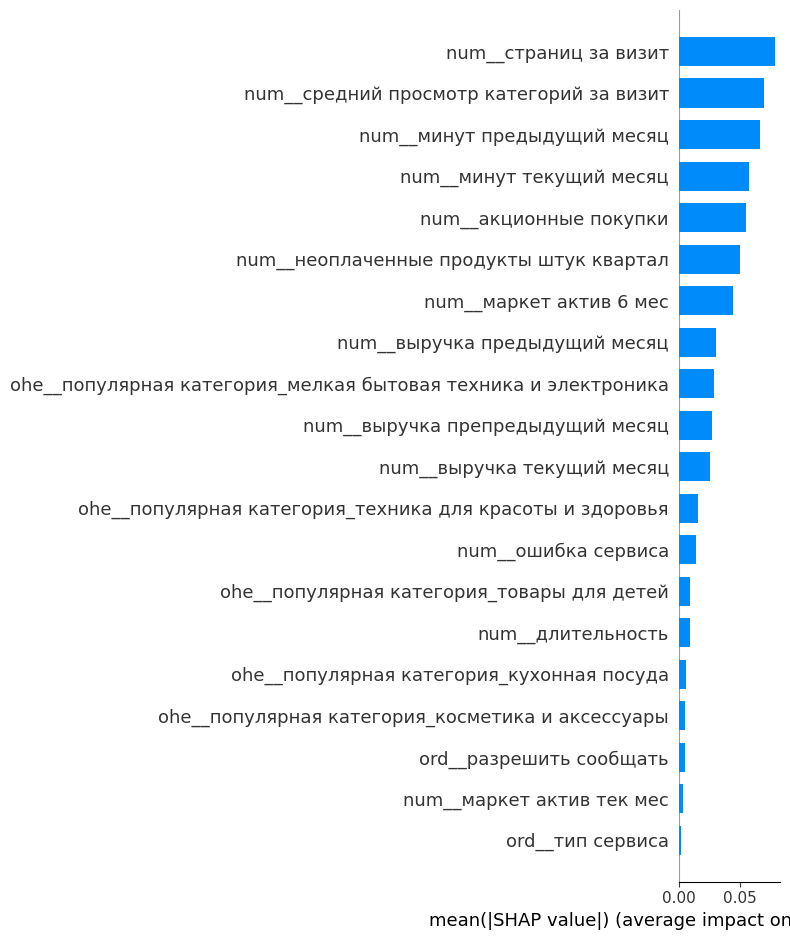

In [88]:
shap.summary_plot(shap_values[:, :, 1], X_train_trans, plot_type="bar")

Вывод: 

Наиболее важные признаки:
- страниц за визит
- средний просмотр категорий за визит
- минут предыдущий месяц
- минут текущий месяц
- акционные покупки

Менее важные признаки:
- тип сервиса стандарт
- маркет актив тек мес
- разрешить сообщать
- популярная категория косметика и аксессуары
- популярная категория кухонная посуда

## Сегментация покупателя

In [89]:
y_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]
pred_df = X_test
pred_df['y_test'] = y_test
pred_df['y_proba_1'] = y_proba
pred_df.head()

,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц,минут предыдущий месяц,минут текущий месяц,y_test,y_proba_1
810,стандарт,да,4.1,4,606,0.15,техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0,0.013336
303,премиум,нет,1.4,4,684,0.94,товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,1,0.989183
956,премиум,да,3.3,4,488,0.13,домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0,0.102073
150,премиум,да,3.5,3,1057,0.35,домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,1,0.817461
583,стандарт,нет,5.5,4,147,0.99,мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,1,0.505665


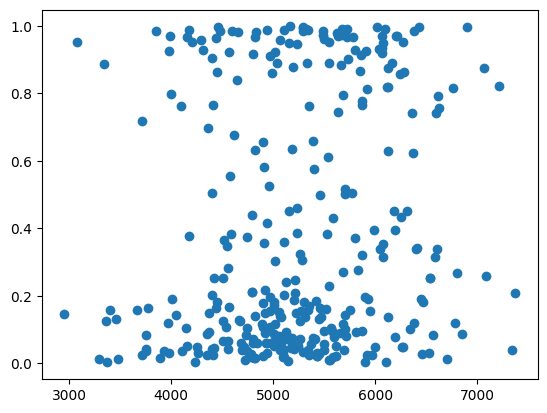

In [90]:
# Посмотрим как распределились данные
plt.scatter(pred_df['выручка текущий месяц'], pred_df['y_proba_1']);

Вывод: большая доля вероятности снижения покупательской активности лежит в диапазоне от 3.5 т.р до 6.5 т.р. За большую вероятность примем значения предсказаний от 0.6.

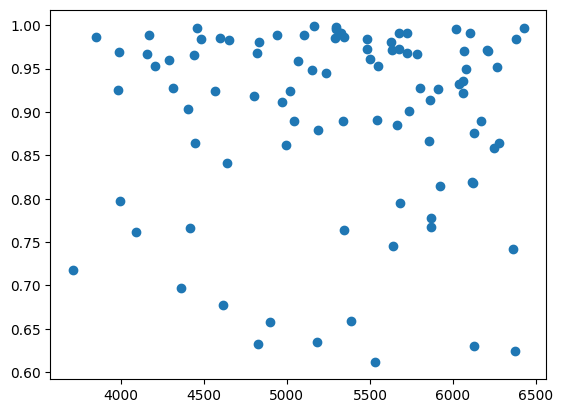

In [91]:
df_neg = pred_df.loc[(pred_df['y_proba_1'] > 0.6) & ((pred_df['выручка текущий месяц'] > 3500) & (pred_df['выручка текущий месяц'] < 6500))]
plt.scatter(df_neg['выручка текущий месяц'],df_neg['y_proba_1']);

In [92]:
# посмотрим сколько получилось покупаетелей
df_neg.shape

(93, 18)

Вывод: получили выбрку с информацией о покупателях, чья покупательская активность скорее всего будет снижаться.

Сформируем вторую выборку с покупателями из той же ценовой группы, чья покупательская активность с большой долей вероятности снижаться не будет.

In [93]:
df_pos = pred_df.loc[(pred_df['y_proba_1'] < 0.1) & ((pred_df['выручка текущий месяц'] > 3500 )&(pred_df['выручка текущий месяц'] < 6500))]
df_pos.shape

(95, 18)

In [94]:
# объеденим получившиеся датафрэймы в один
df_pos_neg = pd.concat([df_pos,df_neg])
df_pos_neg.shape

(188, 18)

In [95]:
# введем бинарный признак для графической аналитики
df_pos_neg['y_pred'] = df_pos_neg['y_proba_1'].apply(lambda x: 0 if x < 0.1 else 1)
df_pos_neg['y_pred'].unique()

array([0, 1], dtype=int64)

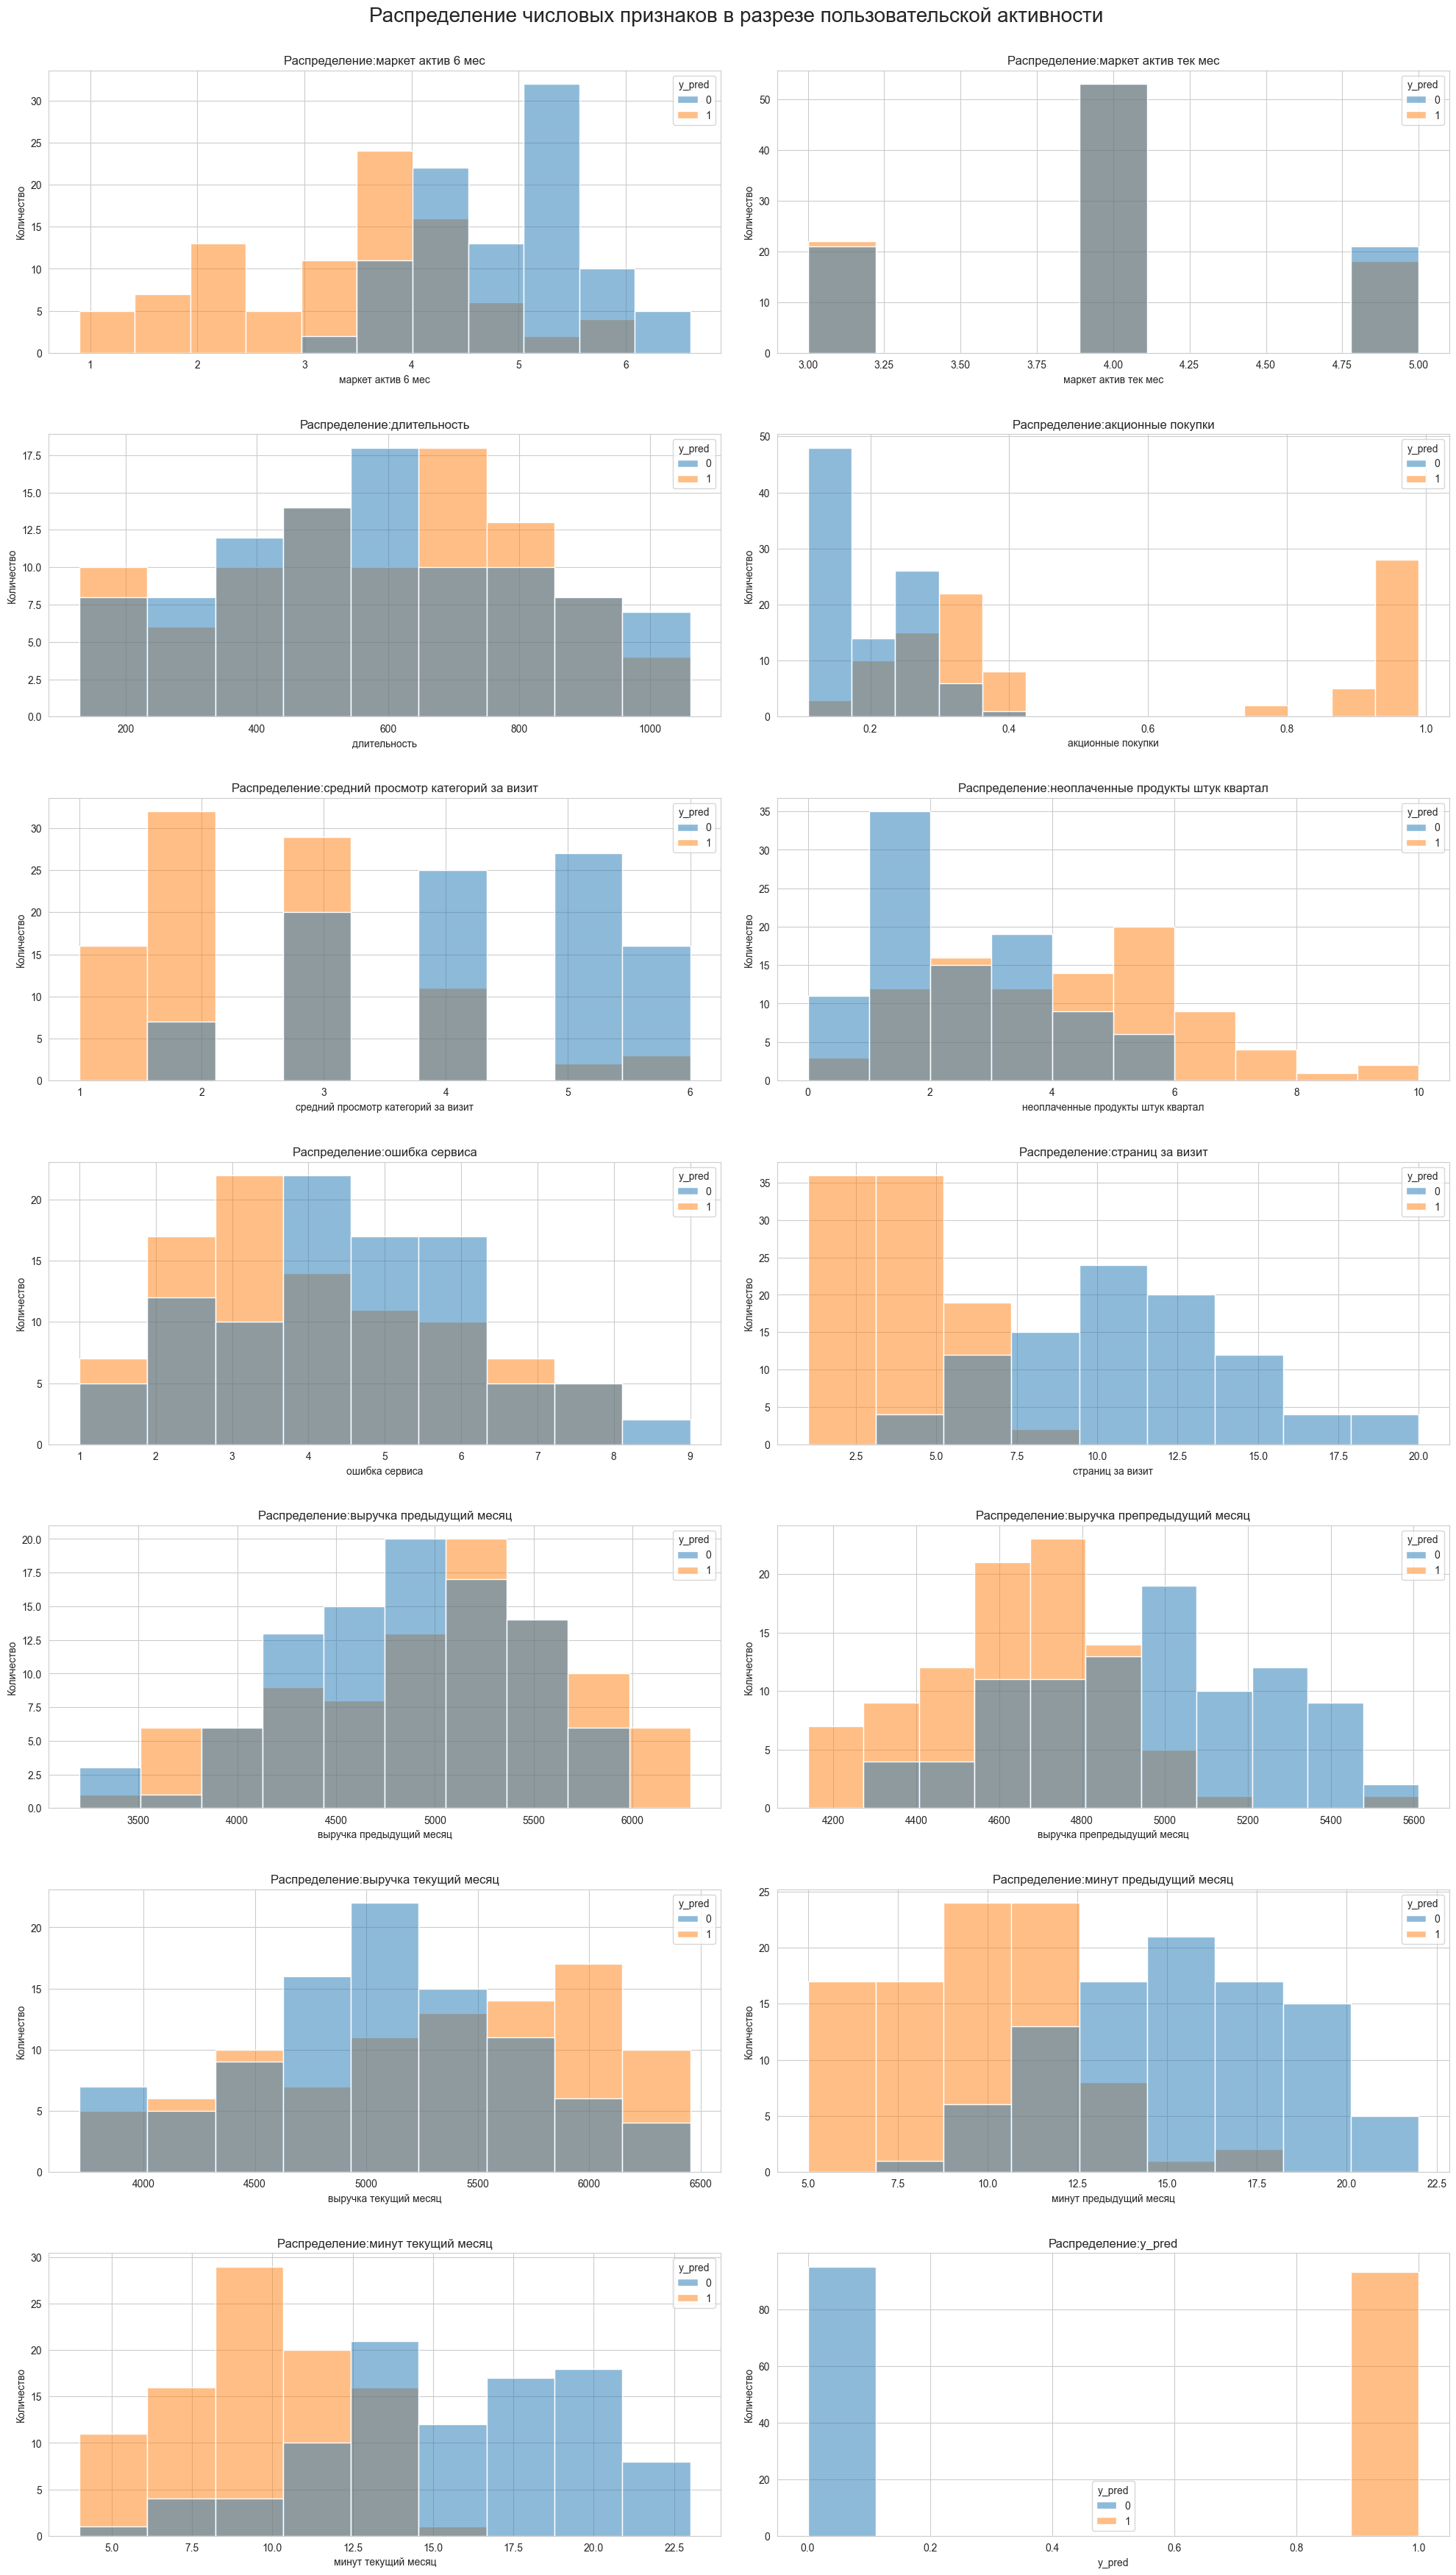

In [96]:
def dist_plot_for2(df):
    
    sns.set_style('whitegrid')
    title = 'Распределение числовых признаков в разрезе пользовательской активности'
    dtype_columns = df.select_dtypes(exclude=[object]).columns
    rows = int(np.ceil(len(dtype_columns)/2))
    
    f, ax  = plt.subplots(rows,2, figsize=(16, 14))
    
    f.tight_layout()
    f.set_figheight(35)
    f.set_figwidth(20)
    plt.rcParams.update({'font.size': 10}) 
    myiterator = cycle(range(0,2))
    
    #Список всех колонок с 0 с шагом 2
    le = dtype_columns[::2]
    #Список всех колонок с 1 с шагом 2
    lo = dtype_columns[1::2]
    
    i=0
    for  ec, oc in zip(le, lo):
        pos = next(myiterator)
        sns.histplot(data=df, x=ec, hue="y_pred", ax   = ax[i,pos])              
        ax[i, pos].set_title(f'Распределение:{ec}')
        ax[i, pos].set_xlabel(f'{ec}')
        ax[i, pos].set_ylabel('Количество')
        
        pos = next(myiterator)
        sns.histplot(data=df, x=oc, hue="y_pred", ax   = ax[i, pos])
        ax[i, pos].set_title(f'Распределение:{oc}')
        ax[i, pos].set_xlabel(f'{oc}')
        ax[i, pos].set_ylabel('Количество')       
    
        i+=1
           
            
    plt.suptitle(title, fontsize=20, y=1.01)
    plt.show()

dist_plot_for2(df_pos_neg.drop(columns={'y_proba_1','y_test'},axis=1))

Вывод: 
- С большой долей вероятности покуптельская активность будет снижаться среди пользователей проводящих мало времени на сайте. Об этом нам говорят данные графиков, средний просмотр категорий за визит, страниц за визит, и время на сайте. Чем меньше эти показатели, тем ярче виден прогноз снижения активности.

- Ярко видна зависимость снижения покупательской активности от маркетинговой активности. Это видно на графике маркетингвая активность за последние 6 месяцев, где мы видим что чем ниже маркетинговая активность тем выше веротяность снижения покупательской активности.

- Отсутствие акционных покупок так же увеличивает вероятность снижения покупательской активности.

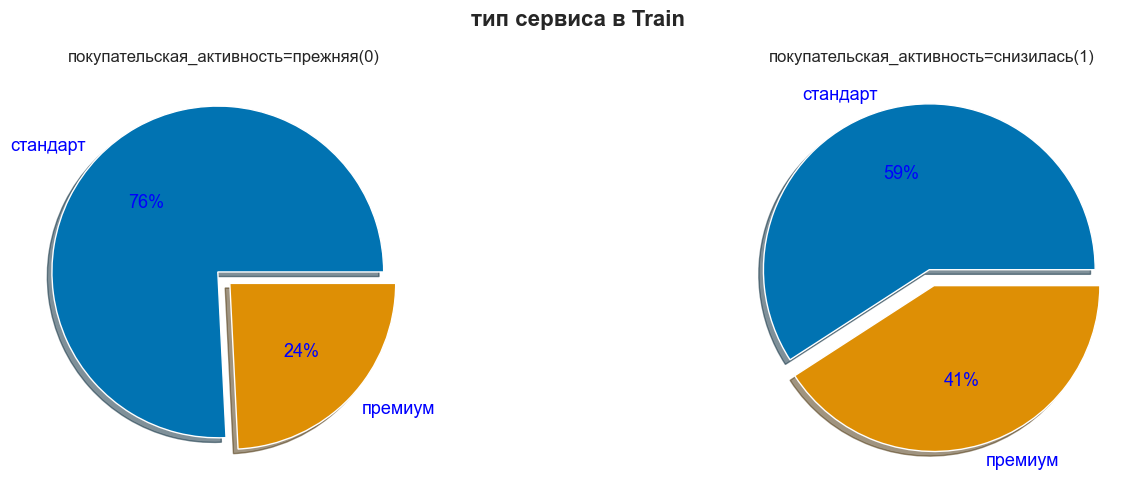

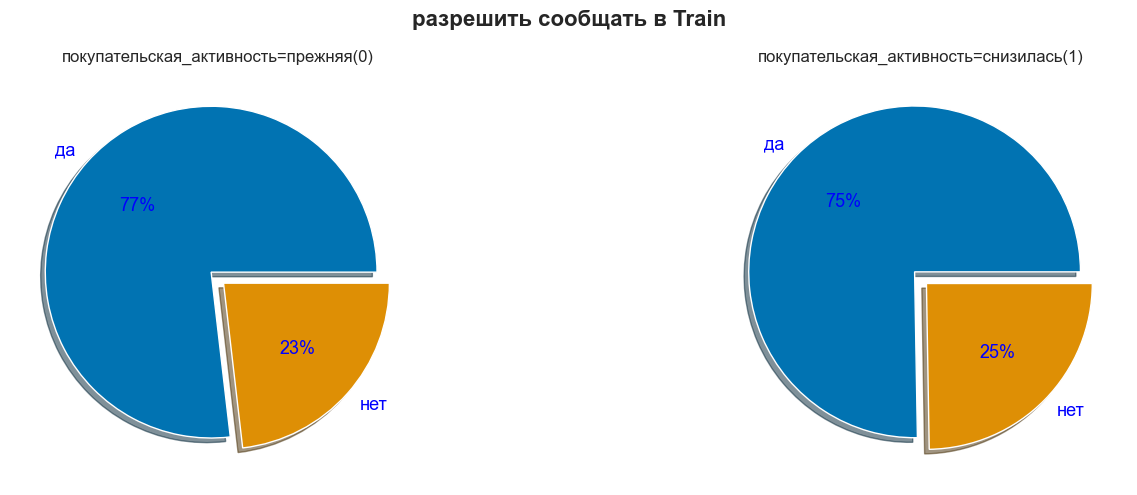

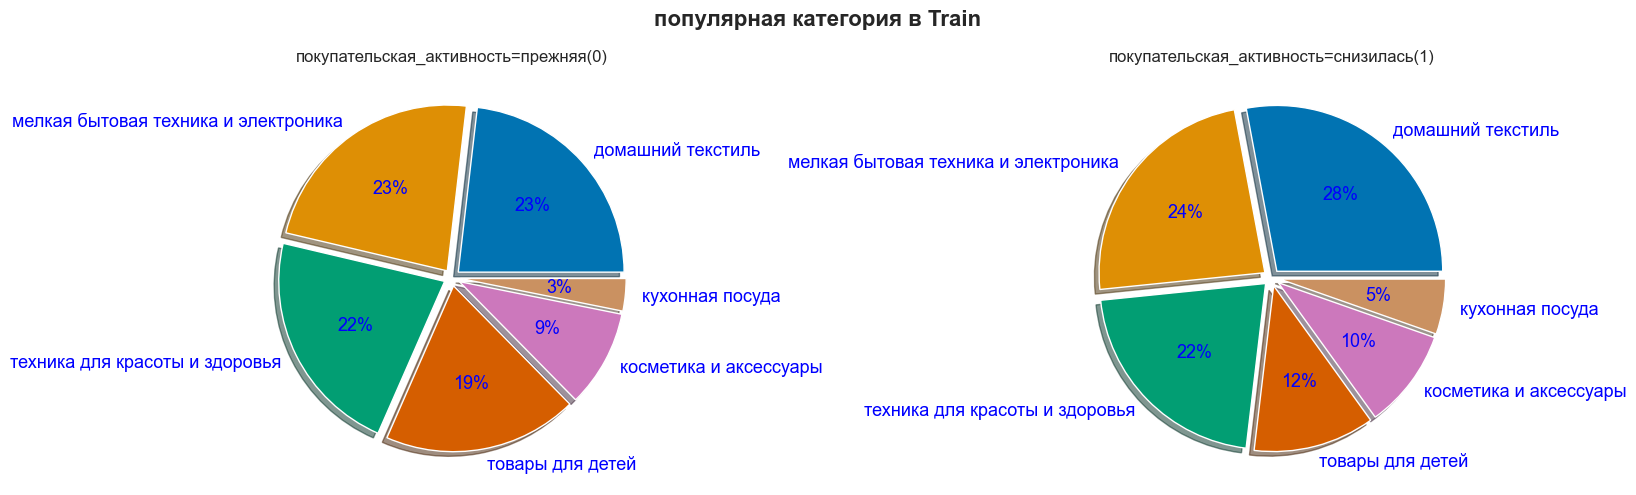

In [97]:
def plot_pie2(df_train, target_col, figsize=(16,5), palette='colorblind', name='Train'):
    df_train0 = df_train.query('y_pred ==0')
    df_train1 = df_train.query('y_pred ==1')
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.flatten()

    pie_colors = sns.color_palette(palette, len(df_train[target_col].unique()))
    ax[0].pie(
        df_train0[target_col].value_counts(),
        shadow=True,
        explode=[0.05] * len(df_train[target_col].unique()),
        autopct='%1.f%%',
        textprops={'size': 13, 'color': 'Blue'},
        colors=pie_colors,
        labels  = df_train0[target_col].unique()
    )
    ax[0].set_aspect('equal')  
    ax[0].set_title('покупательская_активность=прежняя(0)')
    
    pie_colors = sns.color_palette(palette, len(df_train[target_col].unique()))
    ax[1].pie(
        df_train1[target_col].value_counts(),
        shadow=True,
        explode=[0.05] * len(df_train[target_col].unique()),
        autopct='%1.f%%',
        textprops={'size': 13, 'color': 'Blue'},
        colors=pie_colors,
        labels  = df_train0[target_col].unique()
    )
    ax[1].set_title('покупательская_активность=снизилась(1)')
    ax[1].set_aspect('equal')  
    
   
    
    fig.suptitle(f'{target_col} в {name}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    plt.show()

objtype_columns = df_pos_neg.select_dtypes(include=[object]).columns

for i,col in enumerate(objtype_columns):
    plot_pie2(df_pos_neg,col)

Вывод:
- Большая вероятность, что покупательская активность затронет стандартный сегмент покупателей в большей мере по сравнению с категорией премиум.
- Наблюдается тенденция к снижению покупательской активности в категории домашний текстиль и электронник.


В выбранном сегменте покуптелей, для увеличения покупательской активности стоит:

- увеличить маркетинговую активность в отношении данных клиентов;
- улучшить акционные программы, чтобы привлекать постоянных посетителей на сайт;
- улучшить асортимент продукции в категориях текстиль и эелектронника;

## Общий вывод

**Целью исследования было разработать решение для персонализации предложений постоянным клиентам, чтобы увеличить их покупательскую активность.**


**1. Загрузка и изучение данных.**
- `market_file` — данные о поведении покупателя на сайте, коммуникациях с ним и его продуктовом поведении. В данных имеется 1300 записей, пропуски отсутствуют, явные дубликаты отсутствуют, названия столбцов имеют разный тип;
- `market_money` — данные о выручке, получаемой магазином от покупателя за период взаимодействия. В данных имеется 3900 записей, пропуски отсутствуют, явные дубликаты отсутствуют;
- `market_time` — данные о времени, проведенном покупателем на сайте в течение периода. В данных имеется 2600 записей, пропуски отсутствуют, явные дубликаты отсутствуют;
- `money` — данные о среднемесячной прибыли покупателя за последние три месяца. В данных имеется 1300 записей, пропуски отсутствуют, явные дубликаты отсутствуют.


**2. Анализ и подготовка данных.**

- Привели названия столбцов к одному виду.
- Обработали неявные дубликаты, исправили опечатки.
- Явные дубликаты не выявлены.
- Обнаружены выбросы в данных, которые вероятно связаны с сезонностью продаж, особенностью активности отдельных покупателей, также не исключены ошибки ввода данных.
- Для поиска лучшей модели был проведен корреляционный анализ данных. Устранили мультиколлинеарность.
- Подготовили пайплайны для отбора лучшей модели.


**3. Лучшая модель.**


Лучшей моделью является `LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')`

Площадь ROC-кривой на тренировочной выборке: 0.897
Площадь ROC-кривой на тестовой выборке: 0.919


Наиболее важные признаки:

- страниц за визит
- средний просмотр категорий за визит
- минут предыдущий месяц
- акционные покупки
- минут текущий месяц


Менее важные признаки:

- тип сервиса стандарт
- выручка текуций месяц
- маркет актив тек мес
- разрешить сообщать нет
- длительность


**4. Сегментация покупателя и рекомендации.**

С большой долей вероятности покуптельская активность будет снижаться среди пользователей проводящих мало времени на сайте. Об этом нам говорят данные графиков, средний просмотр категорий за визит, страниц за визит, и время на сайте. Чем меньше эти показатели, тем ярче виден прогноз снижения активности.

Ярко видна зависимость снижения покупательской активности от маркетинговой активности. Это видно на графике маркетингвая активность за последние 6 месяцев, где мы видим что чем ниже маркетинговая активность тем выше веротяность снижения покупательской активности.

Отсутствие акционных покупок так же увеличивает вероятность снижения покупательской активности.

Большая вероятность, что покупательская активность затронет стандартный сегмент покупателей в большей мере по сравнению с категорией премиум.
Наблюдается тенденция к снижению покупательской активности в категории домашний текстиль и электронник.


Рекомендации:

- увеличить маркетинговую активность в отношении данных клиентов;
- улучшить акционные программы, чтобы привлекать постоянных посетителей на сайт;
- улучшить асортимент продукции в категориях текстиль и эелектронника;
